In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")
import seaborn as sb
from matplotlib import pyplot as plt

## Problem Statement 

Titanic Survival Prediction

## Data Selection
Titanic Survival dataset taken from [Kaggle](https://storage.googleapis.com/kaggle-competitions-data/kaggle/3136/all.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1573812874&Signature=COtjlEyZlUFaSqv2RFLDWduFg3QIvloTExByha3YUh%2BRmpsLDzsD0aX330NlwdmQYmy9ZeSW2pifTVlsop7oPg5I%2BHZnPmSORR2dpl3i82XRYR%2FaMvmo6KJqQ2txdqimHDUjtHcErB%2BmA1WNDHYfoZppFKY4aYO31eUh8yvP2A9NABm9mH7JEWjjo9OpJCN4%2FmJZ6qkb6v%2FlnNi0hwuF0eJtNUv4WpgTr2fJlI5vDSC3wQUE9Z1AjPp8xzK9OXTpEr%2Fgmd%2FYyzIVBiEI4cv1GxIgoh96mDlV26S99Sdbu30qIBxKNg3jdJ8Y4kQxnE6pV%2FhDSwEvlTEeLQo2Wj6vDQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtitanic.zip)

In [2]:
data_path = "train.csv"

In [3]:
data = pd.read_csv(data_path)

## Exploratory Data Analysis

In [4]:
data.shape

(891, 12)

In [5]:
data.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Andersson, Miss. Erna Alexandra",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [8]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

(7.0, 0.0)

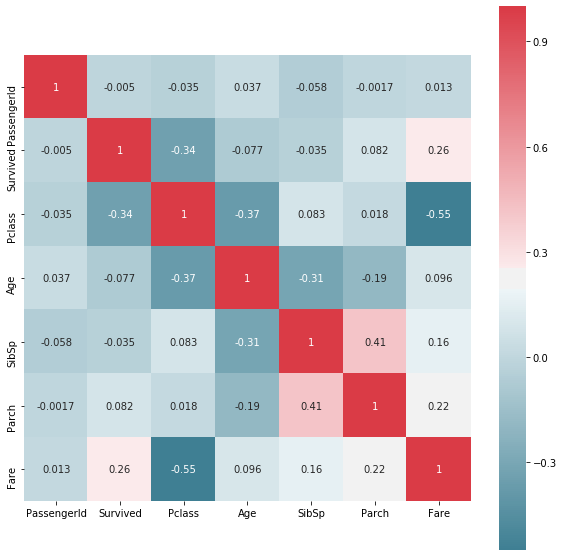

In [9]:
corr = data.corr()
cmap = sb.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(10, 10))
sb.heatmap(corr, cmap=cmap,square=True, annot=True, ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Data Pre-Processing 

In [10]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
data["Age"].fillna(data["Age"].mean(), inplace=True)

data["Embarked"].fillna(data["Embarked"].mode()[0], inplace=True)

data["Cabin"].fillna("missing", inplace=True) #not dropping for certain reason

In [12]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,missing,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,missing,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,missing,S


In [13]:
data["Age"].describe()

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [14]:
data["Age_bin"] = pd.cut(data["Age"],[0,12,19,30,45,100],labels=["child","teen","early working","primary working","last working"])

In [15]:
data.Age_bin.value_counts()

early working      422
primary working    202
last working       103
teen                95
child               69
Name: Age_bin, dtype: int64

In [16]:
data.drop(columns=["Age"], axis=1, inplace=True)

In [17]:
data["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [18]:
data[(data["Fare"]>=0) & (data["Fare"]<8)].shape

(241, 12)

In [19]:
data[(data["Fare"]>=8) & (data["Fare"]<15)].shape

(216, 12)

In [20]:
data[(data["Fare"]>=15) & (data["Fare"]<30)].shape

(194, 12)

In [21]:
data[(data["Fare"]>=30) & (data["Fare"]<60)].shape

(118, 12)

In [22]:
data[(data["Fare"]>=60) & (data["Fare"]<1000)].shape

(122, 12)

In [23]:
data["Fare_bin"] = pd.cut(data["Fare"],[0,7,14,29,59,1000],labels=["First","Second","Third","Fourth","Fifth"])

In [24]:
data.drop(columns=["Fare"], axis=1, inplace=True)

## Data Transformation

In [25]:
data["Name_salutation"] = data["Name"].str.extract(' ([A-Za-z]+)\.')
data["Deck"] = data["Cabin"].str.extract('([A-Z])')
data.drop(columns=["Name","Cabin"], axis=1,inplace=True)

In [26]:
data.Name_salutation.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Mme           1
Countess      1
Capt          1
Ms            1
Sir           1
Don           1
Jonkheer      1
Lady          1
Name: Name_salutation, dtype: int64

In [27]:
data["Deck"].fillna("Z", inplace=True)

In [28]:
data["Name_salutation"] = data["Name_salutation"].apply(lambda x: "Others" if x not in ["Mr","Mrs","Miss","Master"] else x)

In [29]:
data.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Ticket,Embarked,Age_bin,Fare_bin,Name_salutation,Deck
0,1,0,3,male,1,0,A/5 21171,S,early working,Second,Mr,Z
1,2,1,1,female,1,0,PC 17599,C,primary working,Fifth,Mrs,C
2,3,1,3,female,0,0,STON/O2. 3101282,S,early working,Second,Miss,Z
3,4,1,1,female,1,0,113803,S,primary working,Fourth,Mrs,C
4,5,0,3,male,0,0,373450,S,primary working,Second,Mr,Z


In [30]:
data["Name_salutation"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Others     27
Name: Name_salutation, dtype: int64

In [31]:
data.drop(columns=["PassengerId","Ticket"], axis=1, inplace=True)

In [32]:
target = data["Survived"]
# data.drop(columns=["Survived"], axis=1, inplace=True)

In [33]:
data_orig = data

In [34]:
data_orig

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_bin,Fare_bin,Name_salutation,Deck
0,0,3,male,1,0,S,early working,Second,Mr,Z
1,1,1,female,1,0,C,primary working,Fifth,Mrs,C
2,1,3,female,0,0,S,early working,Second,Miss,Z
3,1,1,female,1,0,S,primary working,Fourth,Mrs,C
4,0,3,male,0,0,S,primary working,Second,Mr,Z
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,0,0,S,early working,Second,Others,Z
887,1,1,female,0,0,S,teen,Fourth,Miss,B
888,0,3,female,1,2,S,early working,Third,Miss,Z
889,1,1,male,0,0,C,early working,Fourth,Mr,C


## Feature Selection 

In [35]:
def find_woe_iv(data,column,target):
    woe_list = []
    
    for unique_value in data[column].unique(): 
        if(pd.isnull(unique_value)):
            continue
        req_dict = {
            "Val" : unique_value,
            "Event": data[(data[column] == unique_value) & (data[target]==1)].count()[column],
            "Non-Event": data[(data[column] == unique_value) & (data[target]==0)].count()[column]
        }
        woe_list.append(req_dict)
    
    df = pd.DataFrame(woe_list)
    
    df["Event_Distr"] = df["Event"] / df["Event"].sum()
    df["Non-Event_Distr"] = df["Non-Event"] / df["Non-Event"].sum()
    df["WOE"] = np.log(df["Event_Distr"] / df["Non-Event_Distr"])
    df = df.replace({'WOE': {np.inf: 0, -np.inf: 0}})
    df["IV"] = (df["Event_Distr"] - df["Non-Event_Distr"]) * df["WOE"]
    iv = df["IV"].sum()
    
    
    return df, iv
    

In [36]:
a,b = find_woe_iv(data,"Embarked","Survived")

In [37]:
a

,Val,Event,Non-Event,Event_Distr,Non-Event_Distr,WOE,IV
0,S,219,427,0.640351,0.777778,-0.194425,0.026719
1,C,93,75,0.271930,0.136612,0.688399,0.093153
2,Q,30,47,0.087719,0.085610,0.024337,0.000051


In [38]:
iv_list = []
for column in data.columns:
    if column == 'Survived':
        continue
    else:
        print('WoE and IV for column: '+column)
        df, iv = find_woe_iv(data, column, 'Survived')
        iv_list.append({"Column":column,"IV":round(iv,ndigits=3)})
        print(df)
        print('IV : '+str(round(iv,ndigits=3)))
        print('\n')

iv_df = pd.DataFrame(iv_list)
iv_df = iv_df.sort_values(by="IV", ascending=False)

WoE and IV for column: Pclass
   Val  Event  Non-Event  Event_Distr  Non-Event_Distr       WOE        IV
0    3    119        372     0.347953         0.677596 -0.666483  0.219701
1    1    136         80     0.397661         0.145719  1.003916  0.252928
2    2     87         97     0.254386         0.176685  0.364485  0.028321
IV : 0.501


WoE and IV for column: Sex
      Val  Event  Non-Event  Event_Distr  Non-Event_Distr       WOE        IV
0    male    109        468     0.318713         0.852459 -0.983833  0.525116
1  female    233         81     0.681287         0.147541  1.529877  0.816565
IV : 1.342


WoE and IV for column: SibSp
   Val  Event  Non-Event  Event_Distr  Non-Event_Distr       WOE        IV
0    1    112         97     0.327485         0.176685  0.617076  0.093055
1    0    210        398     0.614035         0.724954 -0.166057  0.018419
2    3      4         12     0.011696         0.021858 -0.625325  0.006355
3    4      3         15     0.008772         0.027322

In [39]:
iv_df

,Column,IV
7,Name_salutation,1.498
1,Sex,1.342
0,Pclass,0.501
8,Deck,0.475
6,Fare_bin,0.399
2,SibSp,0.142
4,Embarked,0.120
3,Parch,0.115
5,Age_bin,0.086


In [40]:
selected_columns = [row["Column"] for _,row in iv_df.iterrows() if row["IV"]>=0.1]

In [41]:
data = data[selected_columns]

In [42]:
data.head()

,Name_salutation,Sex,Pclass,Deck,Fare_bin,SibSp,Embarked,Parch
0,Mr,male,3,Z,Second,1,S,0
1,Mrs,female,1,C,Fifth,1,C,0
2,Miss,female,3,Z,Second,0,S,0
3,Mrs,female,1,C,Fourth,1,S,0
4,Mr,male,3,Z,Second,0,S,0


In [43]:
def coarse_classing(dataframe, index1, index2):
    mean_value =  pd.DataFrame(np.mean(pd.DataFrame([dataframe.iloc[index1],dataframe.iloc[index2]]))).T
    coarsed_col_dropped = dataframe.drop([index1,index2], axis = 0)
    
    coarsed_dataframe = pd.concat([coarsed_col_dropped,mean_value], axis = 0)
    
    return coarsed_dataframe

In [44]:
coarse_classing(df,2,4)

,Event,Event_Distr,IV,Non-Event,Non-Event_Distr,Val,WOE
0,206.0,0.602339,0.102594,481.0,0.876138,Z,-0.374703
1,35.0,0.102339,0.049864,24.0,0.043716,C,0.850582
3,2.0,0.005848,0.001044,2.0,0.003643,G,0.473288
5,7.0,0.020468,0.002003,8.0,0.014572,A,0.339756
6,35.0,0.102339,0.124241,12.0,0.021858,B,1.543729
7,8.0,0.023392,0.013474,5.0,0.009107,F,0.943291
8,0.0,0.000000,-0.000000,1.0,0.001821,T,0.000000
0,24.5,0.071637,0.090896,8.0,0.014572,NaN,1.592311


In [45]:
categorical_variable = ['Sex','Embarked','Deck',"Fare_bin","Name_salutation"]

In [46]:
for cat_var in categorical_variable:
    data[cat_var] = data[cat_var].astype('category')
    data[cat_var] = data[cat_var].cat.codes


In [47]:
data.head()

,Name_salutation,Sex,Pclass,Deck,Fare_bin,SibSp,Embarked,Parch
0,2,1,3,8,1,1,2,0
1,3,0,1,2,4,1,0,0
2,1,0,3,8,1,0,2,0
3,3,0,1,2,3,1,2,0
4,2,1,3,8,1,0,2,0


## Model Selection,  Training and Evaluation 

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size = 0.2)

In [49]:
model_eval_list = []

In [50]:
D_train = xgb.DMatrix(X_train, label = Y_train)
D_test = xgb.DMatrix(X_test, label= Y_test)

param = {
    'eta': 0.2, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 100  # The number of training iterations

model = xgb.train(param, D_train, steps)

preds = model.predict(D_test)

best_preds = np.asarray([np.argmax(line) for line in preds])

precision = precision_score(Y_test, best_preds, average='macro')
recall = recall_score(Y_test, best_preds, average='macro')
accuracy =accuracy_score(Y_test, best_preds)

eval_dict={}
eval_dict["Classifier"] = model.__class__.__name__
eval_dict["Precision"] = precision
eval_dict["Recall"] = recall
eval_dict["Accuracy"] = accuracy
model_eval_list.append(eval_dict)

print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("Accuracy = {}".format(accuracy))

Precision = 0.8273655450100661
Recall = 0.792985842985843
Accuracy = 0.8156424581005587


In [51]:
from xgboost import XGBClassifier

model = XGBClassifier()

model.fit(X_train,Y_train)

pred = model.predict(X_test)

precision = precision_score(Y_test, pred, average='macro')
recall = recall_score(Y_test, pred, average='macro')
accuracy =accuracy_score(Y_test, pred)

eval_dict={}
eval_dict["Classifier"] = model.__class__.__name__
eval_dict["Precision"] = precision
eval_dict["Recall"] = recall
eval_dict["Accuracy"] = accuracy
model_eval_list.append(eval_dict)

print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("Accuracy = {}".format(accuracy))


Precision = 0.8456238643246518
Recall = 0.7937580437580437
Accuracy = 0.8212290502793296


In [52]:
from xgboost import XGBRFClassifier

model = XGBRFClassifier()

model.fit(X_train,Y_train)

pred = model.predict(X_test)

precision = precision_score(Y_test, pred, average='macro')
recall = recall_score(Y_test, pred, average='macro')
accuracy =accuracy_score(Y_test, pred)

eval_dict={}
eval_dict["Classifier"] = model.__class__.__name__
eval_dict["Precision"] = precision
eval_dict["Recall"] = recall
eval_dict["Accuracy"] = accuracy
model_eval_list.append(eval_dict)

print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("Accuracy = {}".format(accuracy))



Precision = 0.8402358354903652
Recall = 0.8045045045045045
Accuracy = 0.8268156424581006


In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
model = DecisionTreeClassifier(criterion = "gini", 
            random_state = 100,max_depth=3, min_samples_leaf=5)

model.fit(X_train, Y_train)

pred = model.predict(X_test)

precision = precision_score(Y_test, pred, average='macro')
recall = recall_score(Y_test, pred, average='macro')
accuracy =accuracy_score(Y_test, pred)

eval_dict={}
eval_dict["Classifier"] = model.__class__.__name__+"_gini"
eval_dict["Precision"] = precision
eval_dict["Recall"] = recall
eval_dict["Accuracy"] = accuracy
model_eval_list.append(eval_dict)

print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("Accuracy = {}".format(accuracy))

Precision = 0.8006666666666666
Recall = 0.7611969111969112
Accuracy = 0.7877094972067039


In [55]:
model = DecisionTreeClassifier(criterion = "entropy", 
            random_state = 100,max_depth=3, min_samples_leaf=5)

model.fit(X_train, Y_train)

pred = model.predict(X_test)

precision = precision_score(Y_test, pred, average='macro')
recall = recall_score(Y_test, pred, average='macro')
accuracy =accuracy_score(Y_test, pred)

eval_dict={}
eval_dict["Classifier"] = model.__class__.__name__+"_entropy"
eval_dict["Precision"] = precision
eval_dict["Recall"] = recall
eval_dict["Accuracy"] = accuracy
model_eval_list.append(eval_dict)

print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("Accuracy = {}".format(accuracy))

Precision = 0.8006666666666666
Recall = 0.7611969111969112
Accuracy = 0.7877094972067039


In [56]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 1000, random_state = 42)

model.fit(X_train, Y_train)

precision = precision_score(Y_test, pred, average='macro')
recall = recall_score(Y_test, pred, average='macro')
accuracy =accuracy_score(Y_test, pred)

eval_dict={}
eval_dict["Classifier"] = model.__class__.__name__
eval_dict["Precision"] = precision
eval_dict["Recall"] = recall
eval_dict["Accuracy"] = accuracy
model_eval_list.append(eval_dict)

print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("Accuracy = {}".format(accuracy))

Precision = 0.8006666666666666
Recall = 0.7611969111969112
Accuracy = 0.7877094972067039


In [57]:
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

In [58]:

# Create classifiers
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rg = RidgeClassifier()
clf_array = [rf, et, knn, svc, rg]
for clf in clf_array:
    model = BaggingClassifier(clf, 
       max_samples=0.4, max_features=5, random_state=42)
    
    model.fit(X_train, Y_train)
    
    precision = precision_score(Y_test, pred, average='macro')
    recall = recall_score(Y_test, pred, average='macro')
    accuracy =accuracy_score(Y_test, pred)

    eval_dict={}
    eval_dict["Classifier"] = "Bagging_"+model.__class__.__name__
    eval_dict["Precision"] = precision
    eval_dict["Recall"] = recall
    eval_dict["Accuracy"] = accuracy
    model_eval_list.append(eval_dict)

    print("Classifier = "+clf.__class__.__name__)
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))
    print("Accuracy = {}".format(accuracy))
    print("-----------***********------------\n")
    

Classifier = RandomForestClassifier
Precision = 0.8006666666666666
Recall = 0.7611969111969112
Accuracy = 0.7877094972067039
-----------***********------------

Classifier = ExtraTreesClassifier
Precision = 0.8006666666666666
Recall = 0.7611969111969112
Accuracy = 0.7877094972067039
-----------***********------------

Classifier = KNeighborsClassifier
Precision = 0.8006666666666666
Recall = 0.7611969111969112
Accuracy = 0.7877094972067039
-----------***********------------

Classifier = SVC
Precision = 0.8006666666666666
Recall = 0.7611969111969112
Accuracy = 0.7877094972067039
-----------***********------------

Classifier = RidgeClassifier
Precision = 0.8006666666666666
Recall = 0.7611969111969112
Accuracy = 0.7877094972067039
-----------***********------------



In [59]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=100, base_estimator= None,learning_rate=0.01, random_state = 1)

model.fit(X_train, Y_train)

precision = precision_score(Y_test, pred, average='macro')
recall = recall_score(Y_test, pred, average='macro')
accuracy =accuracy_score(Y_test, pred)

eval_dict={}
eval_dict["Classifier"] = model.__class__.__name__
eval_dict["Precision"] = precision
eval_dict["Recall"] = recall
eval_dict["Accuracy"] = accuracy
model_eval_list.append(eval_dict)

print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("Accuracy = {}".format(accuracy))

Precision = 0.8006666666666666
Recall = 0.7611969111969112
Accuracy = 0.7877094972067039


In [60]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=3,
    learning_rate=0.9)

model.fit(X_train, Y_train)

precision = precision_score(Y_test, pred, average='macro')
recall = recall_score(Y_test, pred, average='macro')
accuracy =accuracy_score(Y_test, pred)

eval_dict={}
eval_dict["Classifier"] = model.__class__.__name__
eval_dict["Precision"] = precision
eval_dict["Recall"] = recall
eval_dict["Accuracy"] = accuracy
model_eval_list.append(eval_dict)

print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("Accuracy = {}".format(accuracy))

Precision = 0.8006666666666666
Recall = 0.7611969111969112
Accuracy = 0.7877094972067039


In [61]:
eval_df = pd.DataFrame(model_eval_list)

In [62]:
eval_df

,Classifier,Precision,Recall,Accuracy
0,Booster,0.827366,0.792986,0.815642
1,XGBClassifier,0.845624,0.793758,0.821229
2,XGBRFClassifier,0.840236,0.804505,0.826816
3,DecisionTreeClassifier_gini,0.800667,0.761197,0.787709
4,DecisionTreeClassifier_entropy,0.800667,0.761197,0.787709
5,RandomForestClassifier,0.800667,0.761197,0.787709
6,Bagging_BaggingClassifier,0.800667,0.761197,0.787709
7,Bagging_BaggingClassifier,0.800667,0.761197,0.787709
8,Bagging_BaggingClassifier,0.800667,0.761197,0.787709
9,Bagging_BaggingClassifier,0.800667,0.761197,0.787709
